# Live Series Winner Predictor
This notebook trains a model to predict the winner of a game series as it's being played.

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Series - Sheet1.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.drop(columns=['Note'])
df['Winner'] = df['Result'].str.extract(r'(Aidan|Oliver)')
df


,Date,Game,Result,Sender,Winner
0,2025-02-04,Archery,Oliver Win,Oliver,Oliver
1,2025-02-04,Knockout,Aidan Win,Oliver,Aidan
2,2025-02-04,Shuffleboard,Oliver Win,Oliver,Oliver
3,2025-02-04,8 Ball,Aidan Win,Oliver,Aidan
4,2025-02-04,Mini Golf,Aidan Win,Oliver,Aidan
...,...,...,...,...,...
640,2025-05-29,Darts,Oliver Win,Oliver,Oliver
641,2025-05-29,8 Ball,Oliver Win,Oliver,Oliver
642,2025-05-29,Mini Golf,Oliver Win,Oliver,Oliver
643,2025-05-29,Shuffleboard,Oliver Win,Oliver,Oliver


In [63]:
# Preprocess series with draw handling
grouped = df.groupby('Date')
series_data = []

for date, group in grouped:
    game_sequence = []
    aidan_wins = 0
    oliver_wins = 0
    draw_count = 0

    for _, row in group.iterrows():
        game = row['Game']
        winner = row['Winner']
        game_sequence.append({'game': game, 'winner': winner if pd.notna(winner) else 'Draw'})

        if winner == 'Aidan':
            aidan_wins += 1
        elif winner == 'Oliver':
            oliver_wins += 1

    series_winner = 'Aidan' if aidan_wins > oliver_wins else 'Oliver'
    series_data.append({
        'date': date,
        'games': game_sequence,
        'series_winner': series_winner
    })

preprocessed_df = pd.DataFrame(series_data)
preprocessed_df['games'][0]


[{'game': 'Archery', 'winner': 'Oliver'},
 {'game': 'Knockout', 'winner': 'Aidan'},
 {'game': 'Shuffleboard', 'winner': 'Oliver'},
 {'game': '8 Ball', 'winner': 'Aidan'},
 {'game': 'Mini Golf', 'winner': 'Aidan'},
 {'game': 'Cup Pong', 'winner': 'Oliver'},
 {'game': 'Darts', 'winner': 'Oliver'},
 {'game': '9 Ball', 'winner': 'Oliver'}]

In [43]:
# Create training data from partial series snapshots
training_samples = []

for _, row in preprocessed_df.iterrows():
    games = row['games']
    series_winner = row['series_winner']

    aidan_wins = 0
    oliver_wins = 0
    draw_count = 0
    game_type_counts = {}

    for i, game in enumerate(games):
        winner = game['winner']
        game_name = game['game']

        if winner == 'Aidan':
            aidan_wins += 1
        elif winner == 'Oliver':
            oliver_wins += 1
        elif winner == 'Draw':
            draw_count += 1

        game_type_counts[game_name] = game_type_counts.get(game_name, 0) + 1

        if i >= 0:
            feature_snapshot = {
                'aidan_wins': aidan_wins,
                'oliver_wins': oliver_wins,
                'draws': draw_count,
                **{f"game_{k}": v for k, v in game_type_counts.items()}
            }
            training_samples.append((feature_snapshot, series_winner))

X_raw = [x for x, y in training_samples]
y = [y for x, y in training_samples]

vec = DictVectorizer(sparse=False)
X = vec.fit_transform(X_raw)


In [44]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score([1 if label == 'Aidan' else 0 for label in y_test], y_prob[:, clf.classes_.tolist().index('Aidan')])
print(f'Accuracy: {accuracy:.2f}, ROC AUC: {roc_auc:.2f}')


Accuracy: 0.81, ROC AUC: 0.83


In [45]:
# Prediction function
def predict_live_series_winner(games_so_far):
    aidan_wins = 0
    oliver_wins = 0
    draw_count = 0
    game_type_counts = {}

    for game in games_so_far:
        winner = game['winner']
        game_name = game['game']

        if winner == 'Aidan':
            aidan_wins += 1
        elif winner == 'Oliver':
            oliver_wins += 1
        elif winner == 'Draw':
            draw_count += 1

        game_type_counts[f'game_{game_name}'] = game_type_counts.get(f'game_{game_name}', 0) + 1

    feature_snapshot = {
        'aidan_wins': aidan_wins,
        'oliver_wins': oliver_wins,
        'draws': draw_count,
        **game_type_counts
    }

    X_input = vec.transform([feature_snapshot])
    proba = clf.predict_proba(X_input)[0]
    return dict(zip(clf.classes_, proba))


In [81]:
# Plotting function
def plot_live_probabilities(game_sequence):
    aidan_probs = []
    oliver_probs = []
    game_labels = []

    for i in range(len(game_sequence)):
        current_games = game_sequence[:i+1]
        probs = predict_live_series_winner(current_games)
        aidan_probs.append(probs.get('Aidan', 0))
        oliver_probs.append(probs.get('Oliver', 0))
        game_labels.append(f"{i+1}: {current_games[-1]['game']}")
        winner = current_games[-1]['winner']
        game_labels[-1] += f" ({winner})"

    plt.figure(figsize=(4, 4))
    plt.plot(game_labels, aidan_probs, label='Aidan', marker='o', color='red')
    plt.plot(game_labels, oliver_probs, label='Oliver', marker='o', color='blue')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.yticks([i/10 for i in range(11)])
    plt.xlabel("Game")
    plt.ylabel("Win Probability")
    plt.title("Live Series Win Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Print the higher probability after the last game
    if aidan_probs and oliver_probs:
        if aidan_probs[-1] > oliver_probs[-1]:
            print(f"Aidan: {aidan_probs[-1]*100:.0f}%")
        else:
            print(f"Oliver: {oliver_probs[-1]*100:.0f}%")


In [47]:
x = [{'game': '8 Ball', 'winner': 'Aidan'},
{'game': '8 Ball', 'winner': 'Oliver'},

{'game': 'Archery', 'winner': 'Aidan'},
{'game': 'Archery', 'winner': 'Oliver'},
{'game': 'Archery', 'winner': 'Draw'},

{'game': 'Darts', 'winner': 'Aidan'},
{'game': 'Darts', 'winner': 'Oliver'},
{'game': 'Darts', 'winner': 'Draw'},

{'game': 'Cup Pong', 'winner': 'Aidan'},
{'game': 'Cup Pong', 'winner': 'Oliver'},

{'game': 'Mini Golf', 'winner': 'Aidan'},
{'game': 'Mini Golf', 'winner': 'Oliver'},
{'game': 'Mini Golf', 'winner': 'Draw'},

{'game': 'Knockout', 'winner': 'Aidan'},
{'game': 'Knockout', 'winner': 'Oliver'},
{'game': 'Knockout', 'winner': 'Draw'},

{'game': 'Shuffleboard', 'winner': 'Aidan'},
{'game': 'Shuffleboard', 'winner': 'Oliver'},
{'game': 'Shuffleboard', 'winner': 'Draw'},

{'game': '9 Ball', 'winner': 'Aidan'},
{'game': '9 Ball', 'winner': 'Oliver'},]

0     {'game': '8 Ball', 'winner': 'Aidan'},
1     {'game': '8 Ball', 'winner': 'Oliver'},

2     {'game': 'Archery', 'winner': 'Aidan'},
3     {'game': 'Archery', 'winner': 'Oliver'},
4     {'game': 'Archery', 'winner': 'Draw'},

5     {'game': 'Darts', 'winner': 'Aidan'},
6     {'game': 'Darts', 'winner': 'Oliver'},
7     {'game': 'Darts', 'winner': 'Draw'},

8     {'game': 'Cup Pong', 'winner': 'Aidan'},
9     {'game': 'Cup Pong', 'winner': 'Oliver'},

10    {'game': 'Mini Golf', 'winner': 'Aidan'},
11    {'game': 'Mini Golf', 'winner': 'Oliver'},
12    {'game': 'Mini Golf', 'winner': 'Draw'},

13    {'game': 'Knockout', 'winner': 'Aidan'},
14    {'game': 'Knockout', 'winner': 'Oliver'},
15    {'game': 'Knockout', 'winner': 'Draw'},

16    {'game': 'Shuffleboard', 'winner': 'Aidan'},
17    {'game': 'Shuffleboard', 'winner': 'Oliver'},
18    {'game': 'Shuffleboard', 'winner': 'Draw'},

19    {'game': '9 Ball', 'winner': 'Aidan'},
20    {'game': '9 Ball', 'winner': 'Oliver'},

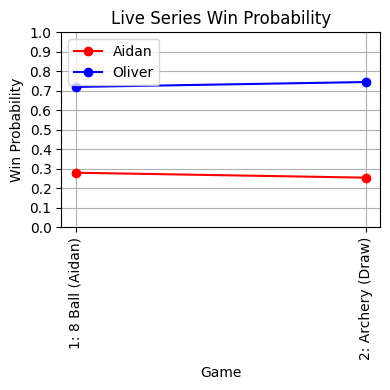

Oliver: 75%


In [144]:
live_series = [
    x[0],
    x[4]
]

plot_live_probabilities(live_series)